In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import time
from statsmodels.regression.rolling import RollingOLS
from scipy.stats import spearmanr
import statsmodels.api as sm
import pandas.tseries.offsets as toffsets
from itertools import dropwhile, chain, product
from datetime import datetime
from typing import Dict, Tuple, List, Union
from collections import namedtuple
import os
import sys

# 数据读取

In [2]:
sw_price = pd.read_excel('data.xlsx', sheet_name = 'sw_price')
index_price = pd.read_excel('data.xlsx', sheet_name = 'index_price')
sw_price['trade_date'] = pd.to_datetime(sw_price['trade_date'])
index_price['trade_date'] = pd.to_datetime(index_price['trade_date'])
sw_price = sw_price.set_index(sw_price.trade_date)
sw_price['Weekly_return'] = sw_price.groupby('code')['close'].pct_change(5)
index_price = index_price.set_index(index_price.trade_date)
index_price['Weekly_return_index'] = index_price.groupby('code')['close'].pct_change(5)

# 构建投资者情绪指数

基本思路是首先计算31个申万一级行业周收益率以及其相对沪深300指数的周Beta系数；然后测算31个申万一级行业周收益率与其周Beta系数的Spearman秩相关系数;最后以Spearman秩相关系数为基础构建国信投资者情绪指数GSISI。

## 行业收益率与市场收益率滚动回归

In [3]:
def getCapmBeta(x,y,sample_list,window=252,cov = 'nonrobust'):
# x:index return
# y:assets return(panel data)
# sample_list:sample ID
    x = pd.DataFrame(x)
    beta = []
    pvalue = []
    for i in sample_list:
        y_series = pd.DataFrame(y[y.iloc[:,1]==i].iloc[:,-1])
        panel = pd.concat([x,y_series],axis=1,join = 'inner')
        result = RollingOLS(panel.iloc[:,1],panel.iloc[:,0],window).fit(cov_type=cov)
        beta.append(result.params)
        pvalue.append(result.pvalues)
    return beta, pvalue
    

In [4]:
industry = list(set(sw_price.code))
beta,pvalue = getCapmBeta(index_price['Weekly_return_index'],sw_price,industry,window = 100,cov = 'HCCM')
beta

[            Weekly_return_index
 trade_date                     
 2014-01-02                  NaN
 2014-01-03                  NaN
 2014-01-06                  NaN
 2014-01-07                  NaN
 2014-01-08                  NaN
 ...                         ...
 2023-01-04             0.559158
 2023-01-05             0.536197
 2023-01-06             0.523794
 2023-01-09             0.504330
 2023-01-10             0.481264
 
 [2198 rows x 1 columns],             Weekly_return_index
 trade_date                     
 2014-01-02                  NaN
 2014-01-03                  NaN
 2014-01-06                  NaN
 2014-01-07                  NaN
 2014-01-08                  NaN
 ...                         ...
 2023-01-04             0.972870
 2023-01-05             0.969259
 2023-01-06             0.953956
 2023-01-09             0.937926
 2023-01-10             0.924143
 
 [2198 rows x 1 columns],             Weekly_return_index
 trade_date                     
 2014-01-02           

## 计算行业收益率与市场收益率的斯皮尔曼秩相关系数

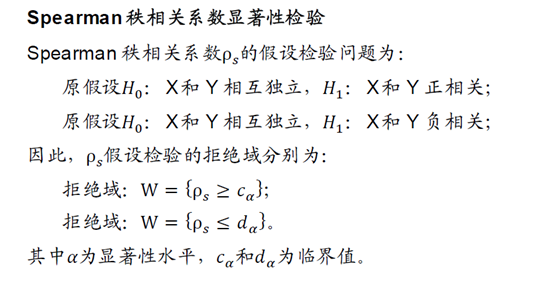

In [5]:
beta_panel = pd.concat([beta[0],beta[1]],axis=1,join='inner')
for i in range(2,len(beta)):
    beta_panel = pd.concat([beta_panel,beta[i]],axis=1,join='inner')
date = list(beta[0].index)
params = []
pvalues = []
for t in range(len(date)):
    cross_section_return = sw_price[sw_price.trade_date==date[t]].iloc[:,-1]
    cross_section_beta = beta_panel[beta_panel.index==date[t]]
    panel = pd.concat
    coef, p = spearmanr(cross_section_return, cross_section_beta.T)
    params.append(coef)
    pvalues.append(p)
    print('Spearmans correlation coefficient: %.3f' % coef)
    

Spearmans correlation coefficient: nan
Spearmans correlation coefficient: nan
Spearmans correlation coefficient: nan
Spearmans correlation coefficient: nan
Spearmans correlation coefficient: nan
Spearmans correlation coefficient: nan
Spearmans correlation coefficient: nan
Spearmans correlation coefficient: nan
Spearmans correlation coefficient: nan
Spearmans correlation coefficient: nan
Spearmans correlation coefficient: nan
Spearmans correlation coefficient: nan
Spearmans correlation coefficient: nan
Spearmans correlation coefficient: nan
Spearmans correlation coefficient: nan
Spearmans correlation coefficient: nan
Spearmans correlation coefficient: nan
Spearmans correlation coefficient: nan
Spearmans correlation coefficient: nan
Spearmans correlation coefficient: nan
Spearmans correlation coefficient: nan
Spearmans correlation coefficient: nan
Spearmans correlation coefficient: nan
Spearmans correlation coefficient: nan
Spearmans correlation coefficient: nan
Spearmans correlation coe

Spearmans correlation coefficient: 0.061
Spearmans correlation coefficient: 0.204
Spearmans correlation coefficient: -0.027
Spearmans correlation coefficient: 0.080
Spearmans correlation coefficient: -0.021
Spearmans correlation coefficient: -0.088
Spearmans correlation coefficient: -0.372
Spearmans correlation coefficient: -0.317
Spearmans correlation coefficient: -0.238
Spearmans correlation coefficient: -0.070
Spearmans correlation coefficient: -0.088
Spearmans correlation coefficient: -0.007
Spearmans correlation coefficient: 0.100
Spearmans correlation coefficient: 0.005
Spearmans correlation coefficient: 0.171
Spearmans correlation coefficient: 0.183
Spearmans correlation coefficient: -0.029
Spearmans correlation coefficient: -0.008
Spearmans correlation coefficient: 0.034
Spearmans correlation coefficient: -0.053
Spearmans correlation coefficient: -0.024
Spearmans correlation coefficient: -0.027
Spearmans correlation coefficient: -0.138
Spearmans correlation coefficient: -0.143


Spearmans correlation coefficient: 0.026
Spearmans correlation coefficient: 0.177
Spearmans correlation coefficient: -0.035
Spearmans correlation coefficient: -0.051
Spearmans correlation coefficient: -0.088
Spearmans correlation coefficient: -0.178
Spearmans correlation coefficient: -0.204
Spearmans correlation coefficient: -0.269
Spearmans correlation coefficient: -0.160
Spearmans correlation coefficient: 0.034
Spearmans correlation coefficient: 0.226
Spearmans correlation coefficient: 0.117
Spearmans correlation coefficient: 0.060
Spearmans correlation coefficient: -0.079
Spearmans correlation coefficient: -0.136
Spearmans correlation coefficient: -0.138
Spearmans correlation coefficient: -0.111
Spearmans correlation coefficient: -0.216
Spearmans correlation coefficient: -0.193
Spearmans correlation coefficient: -0.020
Spearmans correlation coefficient: -0.197
Spearmans correlation coefficient: -0.384
Spearmans correlation coefficient: -0.150
Spearmans correlation coefficient: -0.19

Spearmans correlation coefficient: -0.518
Spearmans correlation coefficient: -0.166
Spearmans correlation coefficient: -0.069
Spearmans correlation coefficient: -0.112
Spearmans correlation coefficient: -0.092
Spearmans correlation coefficient: -0.037
Spearmans correlation coefficient: -0.201
Spearmans correlation coefficient: -0.161
Spearmans correlation coefficient: -0.206
Spearmans correlation coefficient: -0.128
Spearmans correlation coefficient: -0.169
Spearmans correlation coefficient: -0.202
Spearmans correlation coefficient: -0.100
Spearmans correlation coefficient: 0.060
Spearmans correlation coefficient: -0.069
Spearmans correlation coefficient: -0.160
Spearmans correlation coefficient: -0.133
Spearmans correlation coefficient: -0.092
Spearmans correlation coefficient: -0.121
Spearmans correlation coefficient: 0.005
Spearmans correlation coefficient: -0.037
Spearmans correlation coefficient: -0.183
Spearmans correlation coefficient: -0.170
Spearmans correlation coefficient: -

Spearmans correlation coefficient: 0.158
Spearmans correlation coefficient: 0.218
Spearmans correlation coefficient: 0.231
Spearmans correlation coefficient: 0.146
Spearmans correlation coefficient: 0.065
Spearmans correlation coefficient: 0.007
Spearmans correlation coefficient: -0.159
Spearmans correlation coefficient: -0.194
Spearmans correlation coefficient: -0.348
Spearmans correlation coefficient: -0.392
Spearmans correlation coefficient: -0.276
Spearmans correlation coefficient: -0.279
Spearmans correlation coefficient: -0.254
Spearmans correlation coefficient: -0.120
Spearmans correlation coefficient: -0.060
Spearmans correlation coefficient: -0.098
Spearmans correlation coefficient: -0.097
Spearmans correlation coefficient: 0.154
Spearmans correlation coefficient: -0.159
Spearmans correlation coefficient: -0.154
Spearmans correlation coefficient: -0.106
Spearmans correlation coefficient: -0.333
Spearmans correlation coefficient: -0.244
Spearmans correlation coefficient: -0.216

Spearmans correlation coefficient: -0.060
Spearmans correlation coefficient: 0.088
Spearmans correlation coefficient: 0.110
Spearmans correlation coefficient: 0.043
Spearmans correlation coefficient: 0.136
Spearmans correlation coefficient: -0.015
Spearmans correlation coefficient: -0.027
Spearmans correlation coefficient: 0.020
Spearmans correlation coefficient: 0.073
Spearmans correlation coefficient: -0.045
Spearmans correlation coefficient: -0.193
Spearmans correlation coefficient: 0.171
Spearmans correlation coefficient: 0.183
Spearmans correlation coefficient: 0.054
Spearmans correlation coefficient: 0.198
Spearmans correlation coefficient: 0.234
Spearmans correlation coefficient: -0.052
Spearmans correlation coefficient: 0.030
Spearmans correlation coefficient: 0.240
Spearmans correlation coefficient: 0.183
Spearmans correlation coefficient: -0.027
Spearmans correlation coefficient: -0.033
Spearmans correlation coefficient: -0.033
Spearmans correlation coefficient: -0.155
Spearm

Spearmans correlation coefficient: 0.246
Spearmans correlation coefficient: 0.223
Spearmans correlation coefficient: -0.079
Spearmans correlation coefficient: -0.102
Spearmans correlation coefficient: -0.063
Spearmans correlation coefficient: -0.251
Spearmans correlation coefficient: -0.208
Spearmans correlation coefficient: -0.350
Spearmans correlation coefficient: -0.230
Spearmans correlation coefficient: -0.198
Spearmans correlation coefficient: -0.079
Spearmans correlation coefficient: 0.068
Spearmans correlation coefficient: 0.096
Spearmans correlation coefficient: 0.016
Spearmans correlation coefficient: 0.071
Spearmans correlation coefficient: 0.075
Spearmans correlation coefficient: -0.123
Spearmans correlation coefficient: 0.068
Spearmans correlation coefficient: 0.031
Spearmans correlation coefficient: 0.055
Spearmans correlation coefficient: 0.161
Spearmans correlation coefficient: -0.061
Spearmans correlation coefficient: -0.096
Spearmans correlation coefficient: 0.085
Spea

Spearmans correlation coefficient: 0.234
Spearmans correlation coefficient: 0.264
Spearmans correlation coefficient: 0.263
Spearmans correlation coefficient: 0.094
Spearmans correlation coefficient: 0.171
Spearmans correlation coefficient: 0.177
Spearmans correlation coefficient: 0.221
Spearmans correlation coefficient: 0.099
Spearmans correlation coefficient: 0.122
Spearmans correlation coefficient: -0.067
Spearmans correlation coefficient: 0.009
Spearmans correlation coefficient: -0.098
Spearmans correlation coefficient: -0.042
Spearmans correlation coefficient: -0.052
Spearmans correlation coefficient: -0.054
Spearmans correlation coefficient: -0.108
Spearmans correlation coefficient: -0.023
Spearmans correlation coefficient: -0.131
Spearmans correlation coefficient: -0.118
Spearmans correlation coefficient: -0.069
Spearmans correlation coefficient: -0.156
Spearmans correlation coefficient: -0.139
Spearmans correlation coefficient: -0.218
Spearmans correlation coefficient: -0.186
Sp

Spearmans correlation coefficient: 0.317
Spearmans correlation coefficient: 0.256
Spearmans correlation coefficient: -0.051
Spearmans correlation coefficient: 0.274
Spearmans correlation coefficient: 0.137
Spearmans correlation coefficient: -0.077
Spearmans correlation coefficient: -0.128
Spearmans correlation coefficient: -0.146
Spearmans correlation coefficient: -0.154
Spearmans correlation coefficient: -0.246
Spearmans correlation coefficient: -0.150
Spearmans correlation coefficient: -0.250
Spearmans correlation coefficient: -0.205
Spearmans correlation coefficient: -0.157
Spearmans correlation coefficient: -0.142
Spearmans correlation coefficient: 0.085
Spearmans correlation coefficient: 0.481
Spearmans correlation coefficient: 0.334
Spearmans correlation coefficient: 0.281
Spearmans correlation coefficient: 0.257
Spearmans correlation coefficient: -0.001
Spearmans correlation coefficient: -0.401
Spearmans correlation coefficient: -0.257
Spearmans correlation coefficient: -0.336
S

Spearmans correlation coefficient: 0.162
Spearmans correlation coefficient: 0.053
Spearmans correlation coefficient: 0.020
Spearmans correlation coefficient: -0.097
Spearmans correlation coefficient: 0.030
Spearmans correlation coefficient: 0.077
Spearmans correlation coefficient: 0.134
Spearmans correlation coefficient: 0.040
Spearmans correlation coefficient: 0.079
Spearmans correlation coefficient: -0.029
Spearmans correlation coefficient: -0.118
Spearmans correlation coefficient: -0.186
Spearmans correlation coefficient: -0.350
Spearmans correlation coefficient: -0.310
Spearmans correlation coefficient: -0.353
Spearmans correlation coefficient: -0.320
Spearmans correlation coefficient: -0.319
Spearmans correlation coefficient: -0.288
Spearmans correlation coefficient: 0.099
Spearmans correlation coefficient: 0.165
Spearmans correlation coefficient: -0.023
Spearmans correlation coefficient: -0.008
Spearmans correlation coefficient: -0.105
Spearmans correlation coefficient: -0.260
Sp

D:\Anaconda\lib\site-packages\matplotlib\cbook\__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
D:\Anaconda\lib\site-packages\matplotlib\axes\_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]


D:\Anaconda\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
D:\Anaconda\lib\site-packages\matplotlib\backends\backend_agg.py:180: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


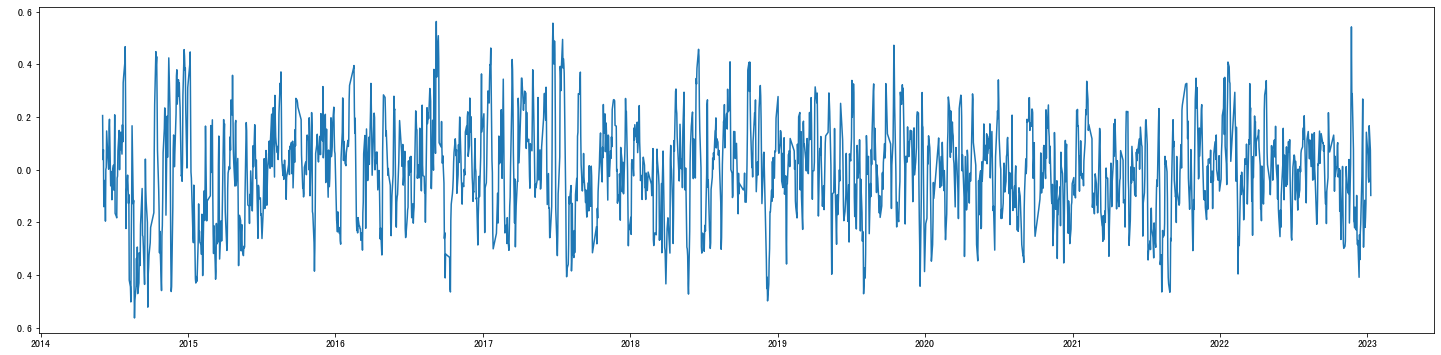

In [16]:
plt.figure(figsize=(25,6))
plt.plot(beta_panel.index,params)

# 2023.2.17：接下来将计算斯皮尔曼相关系数的过程打包成函数，然后仿照源码绘制好看的图

## 用秩相关系数构建投资者情绪指数

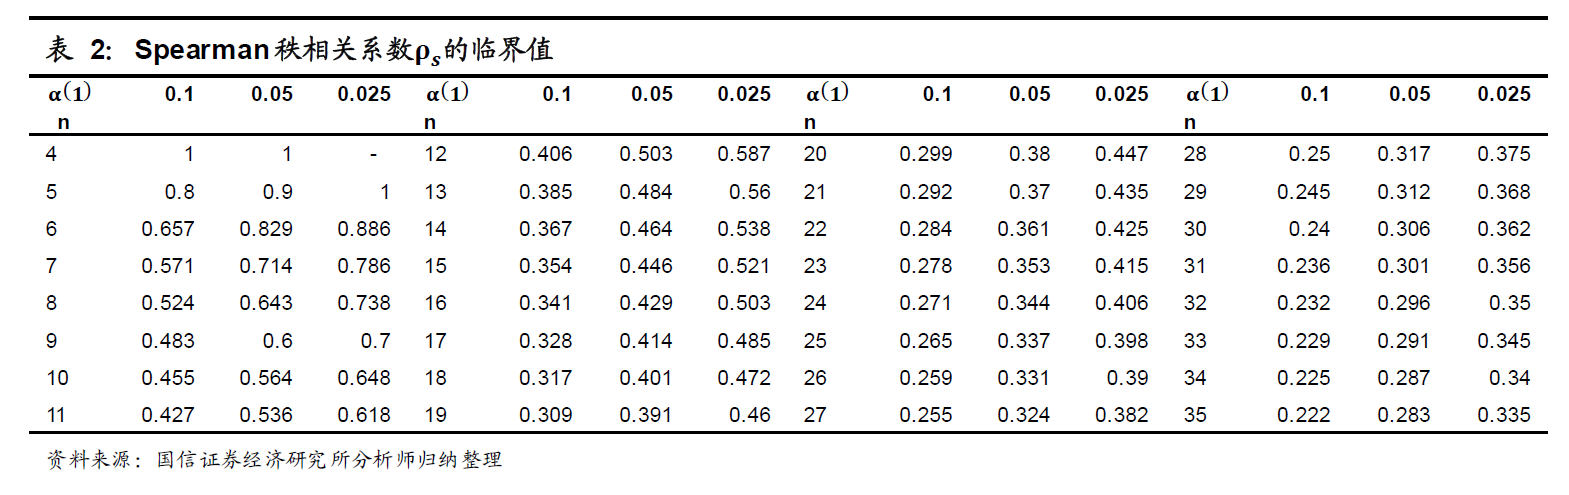

查表可知，alpha=0.05，n=31时，临界值为0.301

In [6]:
GSISI = []
for i in params:
    if i>0.301 or i<-0.301:
        GSISI.append(100*i)
    else:
        GSISI.append(np.nan)


GSISI大于30.1时，投资者乐观情绪上扬；GSISI小于-30.1时，投资者悲观情绪蔓延

### 画图对比CSISI与沪深300走势

D:\Anaconda\lib\site-packages\matplotlib\cbook\__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
D:\Anaconda\lib\site-packages\matplotlib\cbook\__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
D:\Anaconda\lib\site-packages\matplotlib\axes\_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
D:\Anaconda\lib\site-packages\matplotlib\axes\_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy arra

D:\Anaconda\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
D:\Anaconda\lib\site-packages\matplotlib\backends\backend_agg.py:180: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


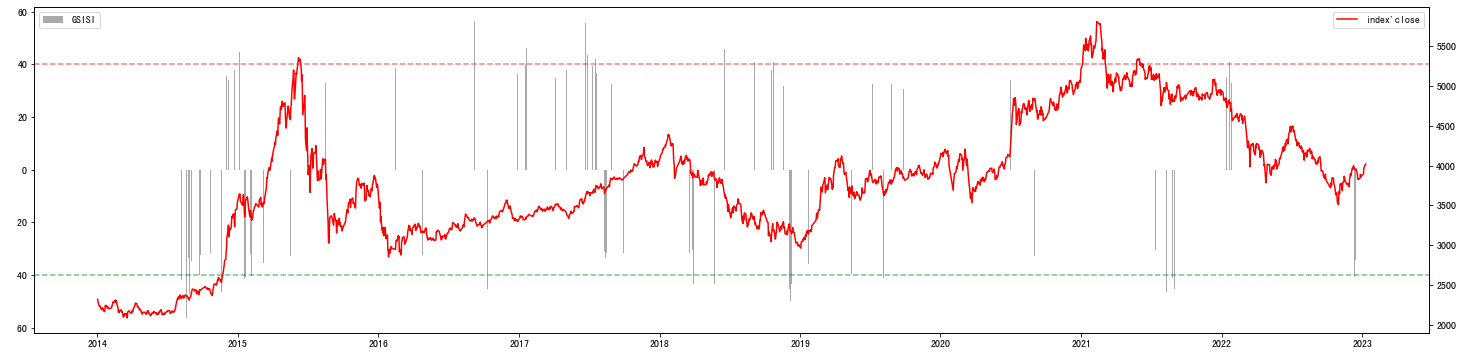

In [87]:
avg:float = np.mean(params)
std:float = np.std(params)
std_up:float = avg + std * 2
std_low:float = avg - std * 2
    
fig = plt.figure(figsize=(25,6))
ax1 = fig.add_subplot(111) 
ax1.bar(index_price.index,GSISI,label='GSISI',color='darkgray')
plt.axhline(40, ls="--", color="red", alpha=0.5)
plt.axhline(-40, ls="--", color="green", alpha=0.5)
ax2 = ax1.twinx()
ax2.plot(index_price.index,index_price.iloc[:,-2],label="index'close",color='r')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')


沪深300走势和GSISI正负基本一致：GSISI为正时沪深300上涨，反之沪深300下跌。但是显著的秩相关系数并没有完全捕捉到市场的每一次变化，比如205年和2021年的牛市

# GSISI择时模型

若GSISI连续两次发出看多(或看空)信号,则看多(或看空)沪深300指数,且保持这个判断,直到连续两次看空(或看多)信号出现,则发生看空(或看多)沪深300指数的反转判断;若GSISI发出多空交叉互现信号,则除最新信号外,前面的交叉信号作废,以最新信号为判断起点,按照前面两条准则重新分析后面的信号。

具体步骤是:

1.若国信投资者情绪指数GSISI>30.1
，则作为看多沪深300的一次警示信号.若紧接着再次GSISI>30.1
，则作为看多沪深300的确认信号,正式看多沪深300,一次判断完成,且保持此判断,直到有相反的判断出现.若紧接着GSISI<-30.1
,则看多沪深300的一次警示信号作废,以此最新的信号为判断起点,进行下一轮的判断.

2.类似地,若国信投资者情绪指数GSISI<-30.1
，则作为看空沪深300的一次警示信号.若紧接着再次GSISI<-30.1
,则作为看空沪深300的确认信号,正式看空沪深300,一次判断完成,且保持此判断,直到有相反的判断出现.若紧接着
,则看空沪深300的一次警示信号作废,以此最新的信号为判断起点,进行下一轮的判断.

In [8]:
import gradient_free_optimizers as gfo
import ipywidgets as ipw
from backtest_toolkit.BackTestTemplate import get_backtesting
from backtest_toolkit.BackTestReport.tear import *


In [9]:
data = index_price.copy()
data["GSISI"] = pd.DataFrame(GSISI,columns=['GSISI'],index=index_price.index)
data.dropna(subset=["GSISI"], inplace=True)
data.index = pd.to_datetime(data.index)
data

,trade_date,code,open,volume,low,high,close,Weekly_return_index,GSISI
trade_date,,,,,,,,,
2014-08-12,2014-08-12,000300.SH,2361.17,91822600,2344.72,2361.17,2357.05,-0.005191,31.491935
2014-08-18,2014-08-18,000300.SH,2366.27,104510000,2361.20,2379.80,2374.56,0.003894,-46.975806
2014-08-19,2014-08-19,000300.SH,2378.89,115850000,2358.97,2379.47,2374.77,0.007518,-34.516129
2014-09-05,2014-09-05,000300.SH,2433.17,133552000,2427.99,2450.63,2449.26,0.047458,31.008065
2014-09-09,2014-09-09,000300.SH,2452.23,118194000,2437.08,2454.89,2445.22,0.038169,31.008065
...,...,...,...,...,...,...,...,...,...
2022-07-18,2022-07-18,000300.SH,4262.15,122601000,4217.51,4300.78,4292.59,-0.014245,40.161290
2022-07-19,2022-07-19,000300.SH,4288.44,103806000,4238.82,4288.44,4269.34,-0.010265,34.153226
2022-08-08,2022-08-08,000300.SH,4142.11,90208100,4135.08,4155.73,4148.07,-0.009695,-32.661290


## 实证回测

In [10]:
def get_gsisi_bt(
    index_price: pd.DataFrame,
    pivot_swprice: pd.DataFrame,
    window: int,
    pct_window: int = 5,
    **kw
) -> namedtuple:
    """GSISI回测

    Args:
        index_price (pd.DataFrame): 默认为hs300收盘价 index-date values-close
        pivot_swprice (pd.DataFrame): 申万行业收盘为 index-date columns-sw_code values-close
        window (int): beta与pct的滚动窗口
        pct_window (int, optional): 收益率计算窗口. Defaults to 5.

    Returns:
        namedtuple: bt_result result,cerebro
    """
    data = index_price.copy()
    data["GSISI"] = pd.DataFrame(GSISI,columns=['GSISI'],index=index_price.index)

    data.dropna(subset=["GSISI"], inplace=True)
    data.index = pd.to_datetime(data.index)

    return get_backtesting(data, "HS300", **kw)

def opt_strat(
    index_price: pd.DataFrame,
    pivot_swprice: pd.DataFrame,
    window: int,
    pct_window: int = 5,
    score_name: str = "_SQN",
    **kw
) -> float:
    """用于寻找参数

    Args:
        index_price (pd.DataFrame): 默认为hs300收盘价 index-date values-close
        pivot_swprice (pd.DataFrame): 申万行业收盘为 index-date columns-sw_code values-close
        window (int): beta与pct的滚动窗口
        pct_window (int, optional): 收益率计算窗口. Defaults to 5.
        score_name (str, optional): 目标参数. Defaults to "_SQN".

    Returns:
        float: 目标参数的数值
    """
    bt_res: namedtuple = get_gsisi_bt(
        index_price, pivot_swprice, window, pct_window, **kw
    )
    anzs = bt_res.result[0].analyzers

    fields: Dict = {
        "_Sharpe": "sharperatio",
        "_SQN": "sqn",
        "_Returns": "rnorm",
    }

    return anzs.getbyname(score_name).get_analysis()[fields[score_name]]

In [11]:
# 寻找最优参数组合
search_space = {'window': np.arange(5, 100),'pct_window':np.arange(5,21,5)}

iterations = 200

opt = gfo.EvolutionStrategyOptimizer(search_space) #创建优化器
opt.search(lambda x:opt_strat(index_price,sw_price,**x,score_name='_Returns',show_log=False), n_iter=iterations,verbosity=['progress_bar'])

best_params_window = {'window': opt.best_para['window'],'pct_window':opt.best_para['pct_window']}

# 用最优参数组合回测
bt_res = get_gsisi_bt(index_price,sw_price,**best_params_window)

2014-08-12, 收盘价Close, 2357.05
2014-08-12, 设置买单 BUY CREATE, 2357.05,信号为:31.49,阈值为:0.30
2014-08-18, BUY EXECUTED, ref:2821, Price: 2366.51, Cost: 953811029.99, Comm 190762.21, Size: 403046.00, Stock: HS300
2014-08-19, 收盘价Close, 2374.77
2014-08-19, 设置卖单SELL CREATE, 2374.77信号为:-34.52,阈值为:-0.30
2014-09-05, SELL EXECUTED, ref:2822, Price: 2432.93, Cost: 953811029.99, Comm 1176697.64, Size: -403046.00, Stock: HS300
2014-09-09, 收盘价Close, 2445.22
2014-09-09, 设置买单 BUY CREATE, 2445.22,信号为:31.01,阈值为:0.30
2014-10-09, BUY EXECUTED, ref:2823, Price: 2480.45, Cost: 988165843.10, Comm 197633.17, Size: 398382.00, Stock: HS300
2014-12-25, 收盘价Close, 3335.42
2014-12-25, 设置卖单SELL CREATE, 3335.42信号为:-31.69,阈值为:-0.30
2015-01-27, SELL EXECUTED, ref:2824, Price: 3613.68, Cost: 988165843.10, Comm 1727549.41, Size: -398382.00, Stock: HS300
2015-06-10, 收盘价Close, 5309.11
2015-06-10, 设置买单 BUY CREATE, 5309.11,信号为:38.23,阈值为:0.30
2015-06-11, BUY EXECUTED, ref:2825, Price: 5305.67, Cost: 1400277867.73, Comm 280055.57, S

### 画图分析HS300看空看多